# Table Length Measurements

Python program for analysing measurements of the length of the lecture table in Auditorium A at NBI.  
There are two measurements each with estimated error of the table length:
1. Measurement with a 30cm ruler.
2. Measurement with a 2m folding ruler.

Each person was asked not only to state the measurement, but also their (gu)estimated uncertainty. None of the persons could see others measurements in order to get the largest degree of independence. Also, the 30cm ruler measurement was asked to be done first. Finally, those measuring were asked to try to measure to the mm, even if precision was less than this, and not to correct any measurement once written down.

Please submit your estimates to the [Table Measurement Result Submission Page](https://docs.google.com/forms/d/1QdxmkUjxxdkDyAZh92QHLgvEb_HsX8fav3915ypBxx0/edit).

### Authors: 
- Troels C. Petersen (Niels Bohr Institute)

### Date:    
- 21-11-2025 (latest update)

***

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit, cost
from scipy import stats
#from scipy.special import erfc                         # Error function, to get integral of Gaussian

Options for the program: 

In [85]:
blinded = False            # Add a random (but fixed) offset to the 30cm and 2m data seperately
save_plots = False

r = np.random             # Random generator
r.seed(42)                # Set a random seed (but a fixed one)

## Initial data analysis:

Before we even look at the look at the data, we decide whether or not we want to blind the analysis by adding a constant to all measurements. This is a good way of working, as we then don't get affected by prior beliefs. Note that a different blinding constant is added for the 30cm ruler and 2m folding rule measurements, so that only after unblinding can the correspondence between the two be considered as a vital cross check.

In [86]:
if blinded:
    blinding30cm = r.normal(0, 0.1)      # I add a constant (Gaussian with +-10cm) to remain "blind"
    blinding2m   = r.normal(0, 0.1)      # I add a constant (Gaussian with +-10cm) to remain "blind"
else:
    blinding30cm = 0
    blinding2m = 0

Define what datafiles we want to look at. Extend it to suit your analysis: 

In [87]:
infiles = ["data_TableMeasurements2025.txt",
           "data_TableMeasurements2024.txt",
           "data_TableMeasurements2023.txt",
           "data_TableMeasurements2022.txt",
           "data_TableMeasurements2021.txt",
           "data_TableMeasurements2020.txt",
           "data_TableMeasurements2019.txt",
           "data_TableMeasurements2018.txt",
           "data_TableMeasurements2017.txt",
           "data_TableMeasurements2016.txt",
           "data_TableMeasurements2015.txt",
           "data_TableMeasurements2014.txt",
           "data_TableMeasurements2013.txt",
           "data_TableMeasurements2012.txt",
           "data_TableMeasurements2011.txt",
           "data_TableMeasurements2010.txt",
           "data_TableMeasurements2009.txt"]

We read in all the data from the `infiles` files (and print the values as a cross check):

In [88]:
L30cm = np.array([])
eL30cm = np.array([])
L2m = np.array([])
eL2m = np.array([])

# Loop over files and open them
for infile in infiles:
    
    tmp_L30cm, tmp_eL30cm, tmp_L2m, tmp_eL2m = np.loadtxt(infile, skiprows=2, unpack=True)
    
    # Note that blinding is applied before storing the values read:
    L30cm = np.append(L30cm, tmp_L30cm + blinding30cm)
    eL30cm = np.append(eL30cm, tmp_eL30cm)
    L2m = np.append(L2m, tmp_L2m + blinding2m)
    eL2m = np.append(eL2m, tmp_eL2m)
    
N_read  = len(L30cm)       # Number of measurements read in total
print(L30cm)
print(f"\n\nRead all {len(infiles)} file(s) which included {N_read} measurements. \n")

[3.777  3.355  3.383  3.342  3.081  3.365  3.364  3.6    3.359  3.368
 3.357  3.373  3.3    3.355  1.221  3.352  3.357  3.661  3.342  3.362
 2.708  3.348  3.375  3.36   3.408  3.374  3.662  3.366  3.468  3.359
 3.305  3.305  3.288  3.369  3.361  3.346  3.357  3.664  3.365  2.654
 3.356  3.37   3.063  3.363  3.354  3.363  3.378  3.355  3.371  3.7
 3.376  3.335  3.365  3.647  3.347  3.341  3.397  3.362  3.357  3.38
 3.273  3.24   3.335  3.37   2.765  3.2    3.345  3.362  3.37   3.353
 3.362  3.29   3.655  3.25   3.364  3.054  3.358  3.365  2.372  3.703
 3.56   3.345  3.385  3.375  3.364  3.31   3.364  3.352  3.363  3.349
 3.035  3.375  3.361  3.065  3.365  3.348  3.366  3.368  3.369  3.362
 3.36   3.364  3.352  3.364  3.635  3.367  3.545  3.651  3.231  3.55
 1.355  3.306  3.364  3.362  3.362  3.039  3.062  3.371  3.351  3.671
 3.368  3.37   3.365  3.364  3.371  3.367  3.355  3.359  3.357  3.363
 3.355  3.387  3.362  3.371  3.355  3.374  3.374  3.396  3.693  3.352
 3.373  3.358  3.36   3.

In [89]:
bad30 = np.where(eL30cm <= 0)[0]
bad2m = np.where(eL2m <= 0)[0]
print(f"30cm: {len(bad30)} non-positive error(s) at indices:", bad30)
if bad30.size:
    print("  corresponding lengths:", L30cm[bad30])
print(f"2m:   {len(bad2m)} non-positive error(s) at indices:", bad2m)
if bad2m.size:
    print("  corresponding lengths:", L2m[bad2m])

# Option A: mark as NaN so weighted routines that drop invalids ignore them
eL30cm[bad30] = np.nan
eL2m[bad2m] = np.nan

30cm: 16 non-positive error(s) at indices: [129 250 471 695 714 745 750 761 778 822 830 906 911 914 917 920]
  corresponding lengths: [3.363  3.362  3.338  3.366  3.371  3.365  3.393  3.3725 3.36   3.366
 3.366  3.355  3.367  3.364  3.38   3.67  ]
2m:   21 non-positive error(s) at indices: [129 250 291 471 537 695 714 744 745 750 761 778 822 830 892 898 906 911
 914 917 920]
  corresponding lengths: [ 3.364  3.375  3.365  3.364  1.375  3.356  3.364 -1.     3.369  3.367
  3.363  3.37   3.362  3.364 -1.     3.35   3.355  3.36   3.365  3.44
  3.64 ]


### First thing: Plot the data!

It is paramount that one plots data - it is the only way to get a good sense of it.

C:\Users\villa\AppData\Local\Temp\ipykernel_45216\810298385.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_raw.tight_layout();


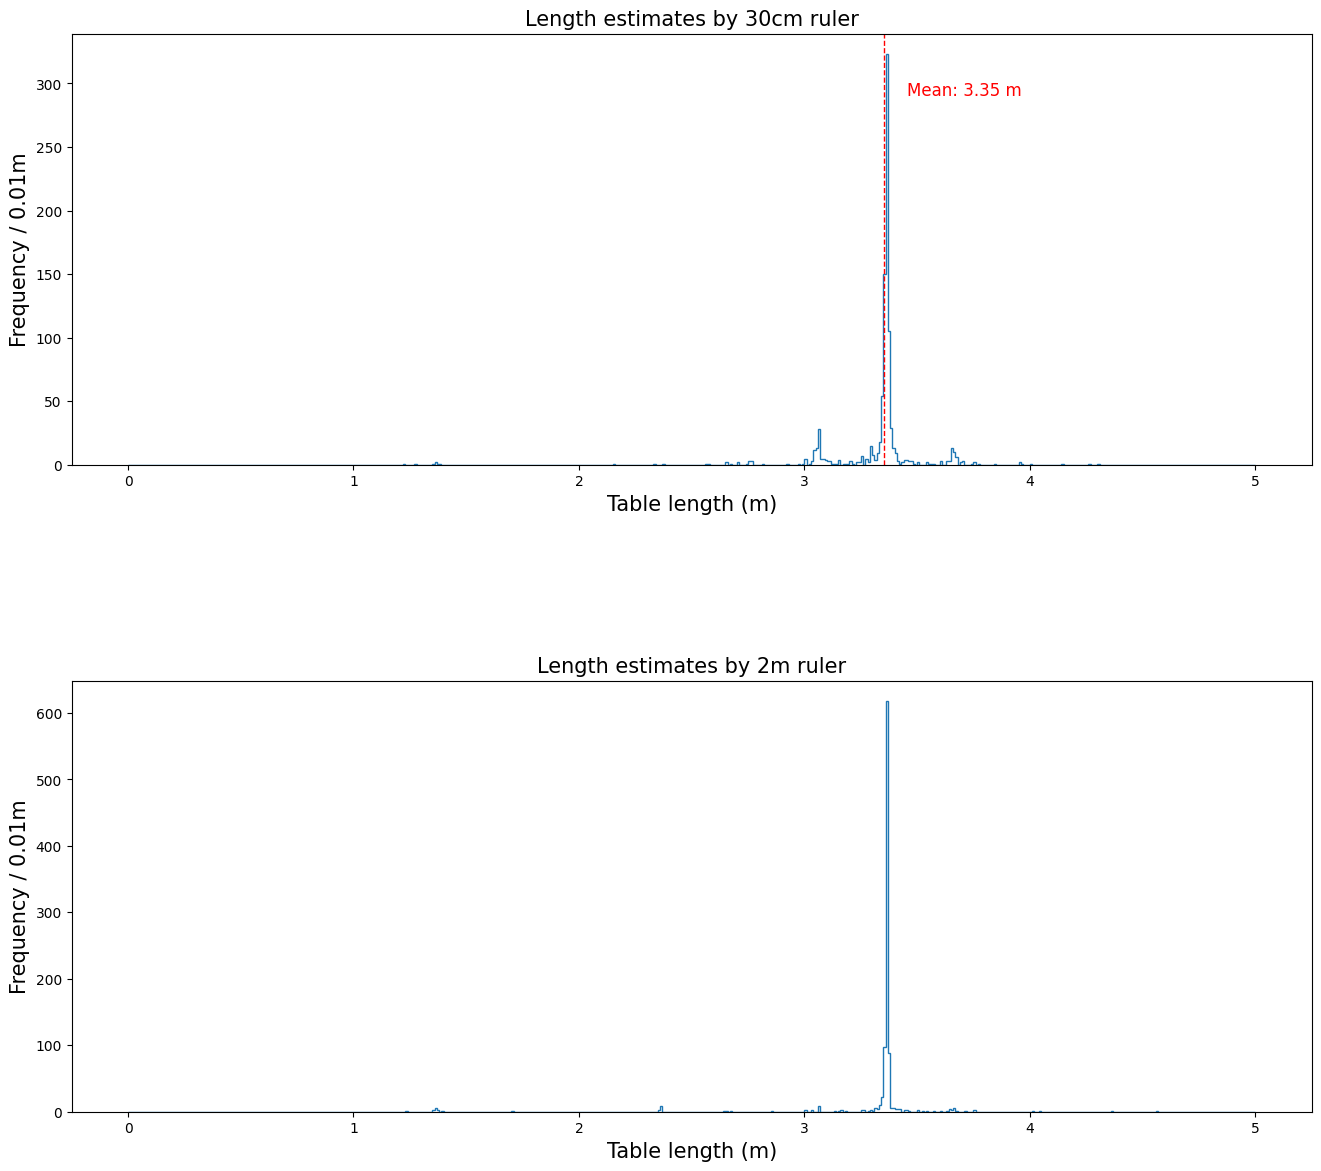

In [90]:
# Carefully consider binning - this might have to be changed, and subplots/inserts are defintely worth considering!
Nbins = 500
minL = 0.0
maxL = 5.0
binwidth = (maxL-minL)/Nbins

# Define two histograms with all the lengths recorded:
fig_raw, ax = plt.subplots(nrows=2, figsize=(16,14), gridspec_kw={'hspace':0.5})
ax_L30cm, ax_L2m = ax

hist_L30cm = ax_L30cm.hist(L30cm, bins=Nbins, range=(minL, maxL), histtype='step', label='30cm data')
ax_L30cm.set_title('Length estimates by 30cm ruler',fontsize=15)
ax_L30cm.set_ylabel('Frequency / 0.01m',fontsize=15)
ax_L30cm.set_xlabel('Table length (m)',fontsize=15)

hist_L2m = ax_L2m.hist(L2m, bins=Nbins, range=(minL, maxL), histtype='step', label='2m data')
ax_L2m.set_title('Length estimates by 2m ruler',fontsize=15)
ax_L2m.set_ylabel('Frequency / 0.01m',fontsize=15)
ax_L2m.set_xlabel('Table length (m)',fontsize=15)

#plot vertical line at mean length
mean_length_30cm = 3.3531

ax_L30cm.axvline(mean_length_30cm, color='r', linestyle='dashed', linewidth=1)
ax_L30cm.text(mean_length_30cm + 0.1, max(hist_L30cm[0])*0.9, f'Mean: {mean_length_30cm:.2f} m', color='r', fontsize=12)

fig_raw.tight_layout();

## 30 cm ruler:

We consider the measurements for the 30cm ruler and focus on that for now. Below is a mean and standard deviation (Std) calculation along with a general Gaussian fit to all the data. Somehow, the Std doesn't seem optimal/right...  

In [91]:
print(f"  Initial estimate of raw data (30 cm ruler):  {L30cm.mean():.3f} +- {L30cm.std(ddof=1)/np.sqrt(len(L30cm)):.3f} m     (Std = {L30cm.std(ddof=1):.3f})")

  Initial estimate of raw data (30 cm ruler):  3.324 +- 0.008 m     (Std = 0.239)


### Next steps:

From the above, you should by now be aware, that there is definitely room for improvement, due to some poor measurement. You want to exclude (or correct?) these, but remember, you should be able to argue for each and every point you remove or correct.

In fact, make sure that PRINT OUT EVERY MEASUREMENT THAT YOU EXCLUDE, along with numbers arguing their case! Barlow 4.2.3 (and the note above this very short section) along with Chauvenet's Criterion might serve as guidelines.

It is now up to you to select in (based on solid **quantified** arguments) the data, and subsequently produce a better estimate of the length of the table in world famous Auditorium A. Good luck...

In [92]:
# Sort the data (perhaps good before printing?) and then exclude those you find dubious:
L30cm = np.sort(L30cm)

import numpy as np
from scipy.stats import norm

def outlier_probability(data, suspicious_value):
    """
    Compute how many standard deviations the suspicious value is from the mean,
    and the probability of observing a value this extreme or more.
    Assumes a normal distribution.
    """
    

    mean = np.mean(data)
    std = np.std(data, ddof=1)    # sample standard deviation

    # number of sigmas
    t_value = abs(suspicious_value - mean) / std

    # probability of being at least t_value sigmas away (two-tailed)
    # norm.cdf(t) gives area BELOW +t
    prob_within = norm.cdf(t_value) - norm.cdf(-t_value)
    prob_outside = 1 - prob_within

    return {
        "mean": mean,
        "std": std,
        "t_value": t_value,
        "prob_outside": prob_outside}

data = L30cm
suspicious_value = L30cm[10]
result = outlier_probability(data, suspicious_value)

print(result, suspicious_value)

# mask = (L30cm >= -100.0) * (L30cm <= 500.0)      # Write your own data selection!!!

# L30cm_subset = L30cm[mask]
# print(f"  The number of measurements used before and after is: {len(L30cm):d} and {len(L30cm_subset):d}")

{'mean': np.float64(3.324475155925156), 'std': np.float64(0.2394291272773415), 't_value': np.float64(3.18037811265588), 'prob_outside': np.float64(0.0014708299960315419)} 2.563


In [93]:
# ...existing code...
# L30cm = np.sort(L30cm)

import numpy as np
from scipy.stats import norm

def iterative_remove_outliers(data, p_threshold=6e-7, min_remaining=3):
 
    data = np.asarray(data)
    
    mask = np.ones(len(data), dtype=bool)
    removed = []
    while True:
        cur_idx = np.flatnonzero(mask)
        cur = data[cur_idx]
        N = cur.size
        if N < min_remaining:
            break
        # compute p for each point using stats excluding that point
        p_vals = np.ones(N)
        t_vals = np.full(N, np.nan)
        for i in range(N):
            others = np.delete(cur, i)
            if others.size < 2:
                p_vals[i] = 1.0
                continue
            mu = others.mean()
            sd = others.std(ddof=1)
            if sd <= 0:
                p_vals[i] = 1.0
                continue
            t = abs(cur[i] - mu) / sd
            p = 2.0 * (1.0 - norm.cdf(t))   # two-tailed
            p_vals[i] = p
            t_vals[i] = t
        min_p = p_vals.min()
        if min_p >= p_threshold:
            break
        # remove the single most extreme point (smallest p)
        worst_rel = int(np.argmin(p_vals))
        worst_orig = int(cur_idx[worst_rel])
        removed.append({
            "index": worst_orig,
            "value": float(data[worst_orig]),
            "t_value": float(t_vals[worst_rel]),
            "p_value": float(p_vals[worst_rel])
        })
        mask[worst_orig] = False

    return data[mask], removed

# Run the iterative removal with 5-sigma ~ 6e-7 threshold
p_threshold_chauvenet = 1.0/(2*len(L30cm))

sort_idx = np.argsort(L30cm)
L30_sorted = L30cm[sort_idx]
eL30_sorted = eL30cm[sort_idx]

L30cm_clean, removed_points = iterative_remove_outliers(L30cm, p_threshold_chauvenet)
mask_sorted = np.ones(len(L30_sorted), dtype=bool)
for r in removed_points:
    mask_sorted[int(r['index'])] = False

# cleaned arrays in sorted order
L30_clean_sorted = L30_sorted[mask_sorted]
eL30_clean_sorted = eL30_sorted[mask_sorted]

print(f"Removed {len(removed_points)} point(s) with p < 6e-7:")
for r in removed_points:
    print(f"  idx={r['index']:d}, value={r['value']:.4f}, t={r['t_value']:.2f}, p={r['p_value']:.2e}")
std_on_the_mean = L30cm_clean.std(ddof=1)/np.sqrt(len(L30cm_clean))
print(f"Remaining N = {len(L30cm_clean)}, mean = {L30cm_clean.mean():.4f}, std(ddof=1) = {L30cm_clean.std(ddof=1):.4f}, std on the mean = {std_on_the_mean:.4f}")

# If you prefer to actually apply the mask to L30cm variable:
# L30cm = L30cm_clean
# ...existing code...

Removed 36 point(s) with p < 6e-7:
  idx=0, value=1.2210, t=9.17, p=0.00e+00
  idx=1, value=1.2750, t=9.33, p=0.00e+00
  idx=2, value=1.3550, t=9.38, p=0.00e+00
  idx=3, value=1.3630, t=9.80, p=0.00e+00
  idx=4, value=1.3650, t=10.33, p=0.00e+00
  idx=5, value=1.3700, t=10.93, p=0.00e+00
  idx=6, value=1.3840, t=11.60, p=0.00e+00
  idx=7, value=2.1560, t=7.21, p=5.58e-13
  idx=8, value=2.3330, t=6.26, p=3.83e-10
  idx=9, value=2.3720, t=6.14, p=8.25e-10
  idx=961, value=4.3050, t=6.22, p=5.08e-10
  idx=960, value=4.2600, t=6.04, p=1.52e-09
  idx=959, value=4.1400, t=5.33, p=9.56e-08
  idx=10, value=2.5630, t=5.25, p=1.49e-07
  idx=11, value=2.5750, t=5.25, p=1.52e-07
  idx=12, value=2.6500, t=4.80, p=1.62e-06
  idx=13, value=2.6540, t=4.83, p=1.37e-06
  idx=14, value=2.6700, t=4.78, p=1.79e-06
  idx=958, value=4.0040, t=4.74, p=2.10e-06
  idx=15, value=2.7000, t=4.67, p=3.08e-06
  idx=16, value=2.7080, t=4.66, p=3.12e-06
  idx=957, value=3.9600, t=4.57, p=4.93e-06
  idx=956, value=3.95

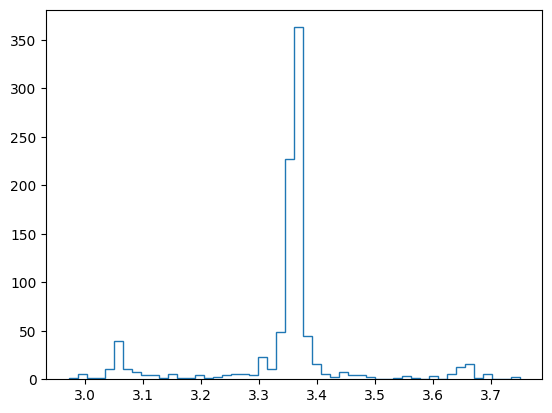

In [94]:
# gaussian fit the clean data
plt.hist(L30cm_clean, bins=50, range=(min(L30cm_clean), max(L30cm_clean)), histtype='step', label='30cm data (cleaned)');
plt.show()

# Define signal PDF:
def gauss_pdf(x, mu, sigma) :
    """Gaussian"""
    return 1.0 / np.sqrt(2*np.pi) / sigma * np.exp( -0.5 * (x-mu)**2 / sigma**2)


# cfit = cost.LeastSquares(x, y, sy, gauss_pdf)


Unbinned Gaussian fit: mu = 3.360551 ± 0.001495, sigma = 0.031281 ± 0.001036


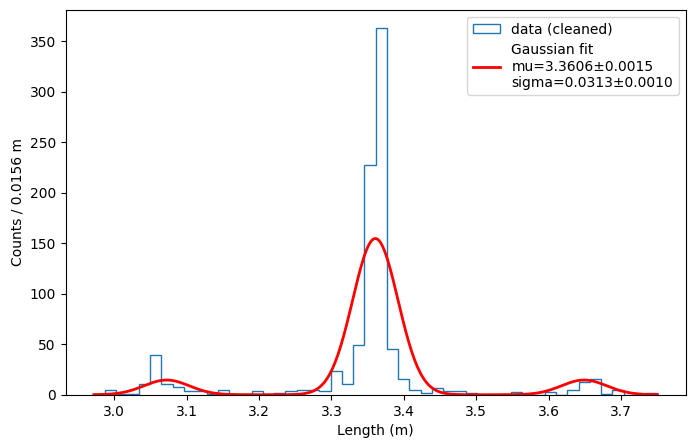

In [95]:
# ...existing code...
# Replace the incomplete ExtendedUnbinnedNLL block with a simple unbinned Gaussian ML fit
# and a plot of the fitted Gaussian over the histogram of the cleaned data.

import numpy as np
from iminuit import Minuit


def tri_gauss_pdf(x, mu, sigma, eps=0.05, delta=0.05):
    """Mixture of one central Gaussian and two smaller symmetric Gaussians at mu +/- delta.
       eps is the relative weight of each side Gaussian compared to the central one.
       The PDF is normalized (sum of weights = 1 + 2*eps)."""
    x = np.asarray(x)
    if sigma <= 0:
        return np.zeros_like(x)
    norm = np.sqrt(2.0 * np.pi) * sigma
    def G(x, m):
        return np.exp(-0.5 * ((x - m) / sigma) ** 2) / norm
    w0 = 1.0
    w_side = float(eps)
    pdf = w0 * G(x, mu) + w_side * G(x, mu - delta) + w_side * G(x, mu + delta)
    return pdf / (w0 + 2.0 * w_side)

# Unbinned negative log-likelihood for the tri-gaussian mixture
def nll_tri(mu, sigma, eps, delta):
    # simple guards to keep optimizer in safe region
    if sigma <= 0 or eps < 0 or delta < 0:
        return 1e9
    vals = tri_gauss_pdf(L30cm_clean, mu, sigma, eps, delta)
    if np.any(vals <= 0):
        return 1e9
    return -np.sum(np.log(vals))

# ensure L30cm_clean exists
if 'L30cm_clean' not in globals():
    L30cm_clean = L30cm  # fallback to original data if cleaning not run

# Gaussian PDF already defined earlier as gauss_pdf(x, mu, sigma)
# Define unbinned negative log-likelihood for the Gaussian (normalized pdf)
def nll_gauss(mu, sigma):
    # enforce physically meaningful sigma
    if sigma <= 0:
        return 1e9
    vals = gauss_pdf(L30cm_clean, mu, sigma)
    # guard against zero pdf values
    if np.any(vals <= 0):
        return 1e9
    return -np.sum(np.log(vals))

# initial guesses
mu0 = float(np.mean(L30cm_clean))
sigma0 = float(np.std(L30cm_clean, ddof=1))

m = Minuit(nll_tri, mu=mu0, sigma=sigma0, eps=0.05, delta=0.3)
m.limits['sigma'] = (1e-6, None)
m.errordef = Minuit.LEAST_SQUARES if hasattr(Minuit, 'LEAST_SQUARES') else 1.0
m.migrad()

mu_hat = m.values['mu']
sigma_hat = m.values['sigma']
mu_err = m.errors['mu']
sigma_err = m.errors['sigma']

print(f"Unbinned Gaussian fit: mu = {mu_hat:.6f} ± {mu_err:.6f}, sigma = {sigma_hat:.6f} ± {sigma_err:.6f}")

# Plot data histogram and fitted Gaussian (scaled to histogram counts)
import matplotlib.pyplot as plt

nbins = 50
counts, bin_edges = np.histogram(L30cm_clean, bins=nbins, range=(min(L30cm_clean), max(L30cm_clean)))
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_width = bin_edges[1] - bin_edges[0]

# scale pdf to histogram counts (area under pdf over range = 1, multiply by N * bin_width)
scale = len(L30cm_clean) * bin_width
x_plot = np.linspace(min(L30cm_clean), max(L30cm_clean), 400)
y_fit = scale * tri_gauss_pdf(x_plot, mu_hat, sigma_hat, eps=m.values['eps'], delta=m.values['delta'])

fig, ax = plt.subplots(figsize=(8,5))
ax.hist(L30cm_clean, bins=nbins, range=(min(L30cm_clean), max(L30cm_clean)), histtype='step', label='data (cleaned)')
ax.plot(x_plot, y_fit, 'r-', lw=2, label=f'Gaussian fit\nmu={mu_hat:.4f}±{mu_err:.4f}\nsigma={sigma_hat:.4f}±{sigma_err:.4f}')
ax.set_xlabel('Length (m)')
ax.set_ylabel(f'Counts / {bin_width:.4f} m')
ax.legend()
plt.show()
# ...existing code...

In [96]:
# weighted mean and std dev calculation after outlier removal

def weighted_mean_std(values, errors):
    weights = 1.0 / (errors ** 2)
    weighted_mean = np.sum(weights * values) / np.sum(weights)
    weighted_variance = 1.0 / np.sum(weights)
    weighted_std = np.sqrt(weighted_variance)
    return weighted_mean, weighted_std
weighted_mean,weighted_std = weighted_mean_std(L30_clean_sorted, eL30_clean_sorted)

print(f"Weighted mean after outlier removal: {weighted_mean:.4f} ± {weighted_std:.4f} m")
# need to mask the errors to match cleaned data


Weighted mean after outlier removal: nan ± nan m


In [97]:
print(L2m)

[ 3.667   3.359   3.365   3.356   3.161   3.363   3.366   3.365   3.359
  3.365   3.367   3.364   1.38    3.365   1.235   3.365   3.371   3.366
  3.361   3.35    3.378   3.365   3.365   3.365   3.364   3.365   2.365
  3.365   3.374   3.349   3.368   3.364   3.323   3.375   4.364   3.36
  3.364   3.663   3.367   2.353   3.367   3.362   3.36    3.362   3.362
  3.364   3.369   3.365   3.361   3.372   3.368   3.365   3.373   3.365
  3.362   3.366   3.372   3.361   3.369   3.372   3.36    3.359   3.362
  3.36    3.362   3.71    3.385   3.375   3.367   3.365   3.355   3.368
  3.465   3.36    3.366   3.36    3.364   3.36    2.364   3.76    3.36
  3.385   3.362   3.362   3.363   3.36    3.363   3.363   3.365   3.359
  3.37    3.36    3.363   3.065   3.364   3.367   3.366   3.367   3.361
  3.364   3.373   3.364   3.361   3.365   3.342   2.364   3.378   3.372
  3.359   3.33    1.365   3.359   3.372   3.363   3.362   3.136   3.375
  3.361   3.354   3.45    3.364   3.361   3.36    3.362   3.365   

In [98]:
# do the same for 2m data, by sorting, removing outliers, and calculating weighted mean and std dev

# L2m = np.sort(L2m)

sort_idx = np.argsort(L2m)
L2_sorted = L2m[sort_idx]
eL2_sorted = eL2m[sort_idx]

p_threshold_chauvenet = 1.0/(2*len(L2m))

L2m_clean, removed_points_2m = iterative_remove_outliers(L2m, p_threshold_chauvenet)

mask_sorted_2m = np.ones(len(L2_sorted), dtype=bool)
for r in removed_points_2m:
    mask_sorted_2m[int(r['index'])] = False
# cleaned arrays in sorted order
L2m_clean_sorted = L2_sorted[mask_sorted_2m]
eL2m_clean_sorted = eL2_sorted[mask_sorted_2m]
print("L2m_clean_sorted length:", len(L2m_clean_sorted))
print("eL2m_clean_sorted length:", len(eL2m_clean_sorted))
print("any nonpositive errors:", np.any(eL2m_clean_sorted <= 0))
print("any NaN errors:", np.any(np.isnan(eL2m_clean_sorted)))


print(f"Removed {len(removed_points_2m)} point(s) with p < 6e-7:")
for r in removed_points_2m:
    print(f"  idx={r['index']:d}, value={r['value']:.4f}, t={r['t_value']:.2f}, p={r['p_value']:.2e}")
std_on_the_mean = L2m_clean_sorted.std(ddof=1)/np.sqrt(len(L2m_clean_sorted))
print(f"Remaining N = {len(L2m_clean_sorted)}, mean = {L2m_clean_sorted.mean():.4f}, std(ddof=1) = {L2m_clean_sorted.std(ddof=1):.4f}, std on the mean = {std_on_the_mean:.4f}")


weighted_mean_2m,weighted_std_2m = weighted_mean_std(L2m_clean_sorted, eL2m_clean_sorted)
print(f"Weighted mean after outlier removal (2m): {weighted_mean_2m:.4f} ± {weighted_std_2m:.4f} m")


#30cm ruler vs. 2m folding rule, unweighted - difference in terms of uncertainty (number of sigmas)




L2m_clean_sorted length: 816
eL2m_clean_sorted length: 816
any nonpositive errors: False
any NaN errors: True
Removed 146 point(s) with p < 6e-7:
  idx=744, value=-1.0000, t=14.02, p=0.00e+00
  idx=892, value=-1.0000, t=15.73, p=0.00e+00
  idx=14, value=1.2350, t=7.85, p=4.22e-15
  idx=240, value=1.3510, t=7.64, p=2.20e-14
  idx=450, value=1.3550, t=7.87, p=3.55e-15
  idx=147, value=1.3640, t=8.10, p=4.44e-16
  idx=12, value=1.3800, t=8.33, p=0.00e+00
  idx=110, value=1.3650, t=8.73, p=0.00e+00
  idx=251, value=1.3650, t=9.10, p=0.00e+00
  idx=537, value=1.3750, t=9.48, p=0.00e+00
  idx=589, value=1.3710, t=9.99, p=0.00e+00
  idx=334, value=1.7040, t=8.63, p=0.00e+00
  idx=649, value=1.3970, t=10.86, p=0.00e+00
  idx=882, value=1.3680, t=11.81, p=0.00e+00
  idx=947, value=1.3660, t=12.82, p=0.00e+00
  idx=950, value=1.3650, t=14.12, p=0.00e+00
  idx=157, value=4.5640, t=8.94, p=0.00e+00
  idx=34, value=4.3640, t=7.70, p=1.40e-14
  idx=39, value=2.3530, t=7.85, p=4.00e-15
  idx=314, val

In [99]:

# choose cleaned arrays if present, otherwise fall back to raw arrays
mean30 = L30cm_clean.mean() if 'L30cm_clean' in globals() else L30cm.mean()
sem30  = (L30cm_clean.std(ddof=1)/np.sqrt(len(L30cm_clean))) if 'L30cm_clean' in globals() else (L30cm.std(ddof=1)/np.sqrt(len(L30cm)))

mean2  = L2m_clean_sorted.mean() if 'L2m_clean_sorted' in globals() else L2m.mean()
sem2   = (L2m_clean_sorted.std(ddof=1)/np.sqrt(len(L2m_clean_sorted))) if 'L2m_clean_sorted' in globals() else (L2m.std(ddof=1)/np.sqrt(len(L2m)))

delta = mean30 - mean2
sigma_delta = np.sqrt(sem30**2 + sem2**2)
nsigma = np.abs(delta) / sigma_delta if sigma_delta > 0 else np.nan

print(f"30cm mean = {mean30:.6f} ± {sem30:.6f} m")
print(f"2m   mean = {mean2:.6f} ± {sem2:.6f} m")
print(f"Difference (30cm - 2m) = {delta:.6f} ± {sigma_delta:.6f} m  -> {nsigma:.2f} sigma")

30cm mean = 3.346028 ± 0.003880 m
2m   mean = 3.322919 ± 0.010868 m
Difference (30cm - 2m) = 0.023109 ± 0.011540 m  -> 2.00 sigma


In [100]:
# ...existing code...
def weighted_mean_std(values, errors, drop_invalid=True, min_error=1e-6):
    """
    Return (weighted_mean, weighted_std). If drop_invalid True, remove non-finite or <=0 errors.
    """
    import numpy as _np
    v = _np.asarray(values)
    e = _np.asarray(errors)
    if v.shape != e.shape:
        raise ValueError("values and errors must have same shape")
    if v.size == 0:
        raise ValueError("no data")
    bad = (~_np.isfinite(e)) | (e <= 0)
    if _np.any(bad):
        if not drop_invalid:
            raise ValueError("errors contain non-positive or non-finite entries")
        keep = ~bad
        v = v[keep]
        e = e[keep]
        if v.size == 0:
            raise ValueError("no valid entries after dropping invalid errors")
    e = _np.maximum(e, min_error)
    w = 1.0 / (e**2)
    wm = _np.sum(w * v) / _np.sum(w)
    wvar = 1.0 / _np.sum(w)
    return wm, _np.sqrt(wvar)

# choose cleaned arrays if present, otherwise fall back to raw arrays
vals30 = L30_clean_sorted if 'L30_clean_sorted' in globals() else L30cm
errs30 = eL30_clean_sorted if 'eL30_clean_sorted' in globals() else eL30cm

vals2 = L2m_clean_sorted if 'L2m_clean_sorted' in globals() else L2m
errs2 = eL2m_clean_sorted if 'eL2m_clean_sorted' in globals() else eL2m

# compute weighted means (drop invalid errors automatically)
wm30, ws30 = weighted_mean_std(vals30, errs30, drop_invalid=True)
wm2,  ws2  = weighted_mean_std(vals2,  errs2,  drop_invalid=True)

# difference and significance
delta = wm30 - wm2
sigma_delta = (ws30**2 + ws2**2)**0.5
nsigma = abs(delta) / sigma_delta if sigma_delta > 0 else float('nan')

print(f"Weighted 30cm = {wm30:.4f} ± {ws30:.4f} m")
print(f"Weighted 2m   = {wm2:.4f} ± {ws2:.4f} m")
print(f"Difference (30cm - 2m) = {delta:.4f} ± {sigma_delta:.4f} m  -> {nsigma:.2f} sigma")
# ...existing code...

Weighted 30cm = 3.3531 ± 0.0002 m
Weighted 2m   = 3.3267 ± 0.0001 m
Difference (30cm - 2m) = 0.0264 ± 0.0002 m  -> 132.86 sigma


0.0005


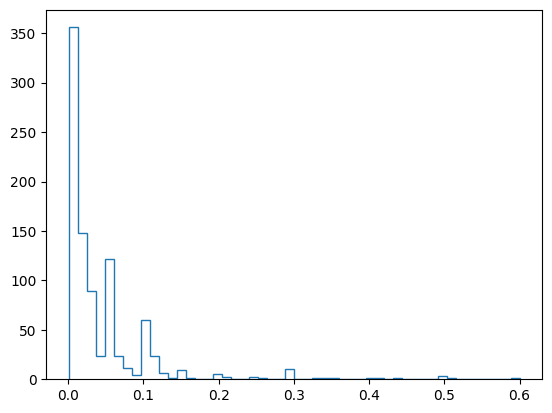

In [102]:
plt.hist(errs30,bins=50, range=(min(errs30), max(errs30)), histtype='step', label='2m errors');
idx = np.argsort(errs30)
errs30_sorted = errs30[idx]
print(errs30_sorted[0])

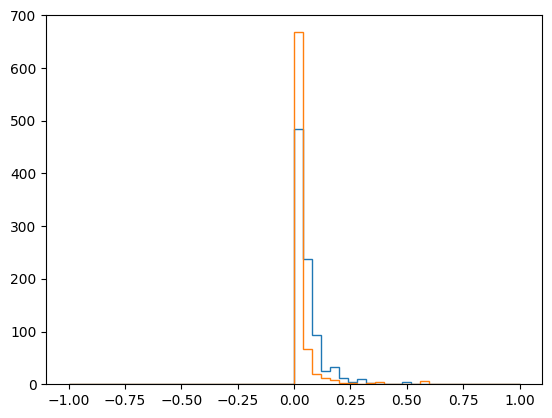

In [110]:

def compute_pulls(values, errors):
    """
    Compute pulls z_i = (x_i - mean_x) / sigma_i.
    Returns (pulls_full, mean, mask) where pulls_full has np.nan for masked entries.
    """
    v = np.asarray(values, dtype=float)
    e = np.asarray(errors, dtype=float)
    if v.shape != e.shape:
        raise ValueError("values and errors must have same shape")
    mask = np.isfinite(v) & np.isfinite(e) & (e > 0)
    pulls_full = np.full_like(v, np.nan, dtype=float)
    if mask.sum() == 0:
        return pulls_full, np.nan, mask
    vk = v[mask]
    ek = e[mask]
    mean_v = float(vk.mean())
    pulls = (vk - mean_v) / ek
    pulls_full[mask] = pulls
    return pulls_full, mean_v, mask
# ...existing code...
def adjust_errors_by_pull_selective(values, errors,
                                    min_error=1e-6,
                                    rchi2_threshold=1.0,
                                    apply_to_below_median=True,
                                    apply_frac=1.0,
                                    max_scale_cap=5.0,
                                    clip_pull_sigma=None):
    """
    Selectively inflate *very small* reported errors based on pull rchi2.
    Behaviour:
      - compute pulls and reduced-chi2 (rchi2) on valid entries
      - if rchi2 > rchi2_threshold compute scale = sqrt(rchi2) (capped by max_scale_cap)
      - apply that multiplicative scale ONLY to errors that are "very low":
          e_i < median_error * apply_frac   (if apply_to_below_median True)
        (set apply_frac < 1.0 to target only extremely small errors)
      - ensure errors >= min_error
      - optionally inflate individual error for extreme pulls (clip_pull_sigma)
    Returns:
      new_errors_full, scale_used, rchi2, pulls_full, mean_value
    """
    v = np.asarray(values, dtype=float)
    e = np.asarray(errors, dtype=float)
    if v.shape != e.shape:
        raise ValueError("values and errors must have same shape")
    pulls_full, mean_v, mask = compute_pulls(v, e)
    new_errors = np.full_like(e, np.nan, dtype=float)
    n_kept = int(mask.sum())
    if n_kept == 0:
        return new_errors, 1.0, np.nan, pulls_full, mean_v

    pulls = pulls_full[mask]
    chi2 = float(np.sum(pulls**2))
    dof = max(1, n_kept - 1)
    rchi2 = chi2 / dof

    # determine scale to use (only apply to low errors)
    if rchi2 > rchi2_threshold:
        scale = float(np.sqrt(rchi2))
        if max_scale_cap is not None:
            scale = min(scale, float(max_scale_cap))
    else:
        scale = 1.0

    # examine the typical error (median is robust)
    ek = np.array(e[mask], copy=True)
    median_e = float(np.median(ek))

    # build mask of entries to scale: those that are below threshold
    if apply_to_below_median:
        low_mask = ek < (median_e * float(apply_frac))
    else:
        # if apply_to_below_median False -> apply to all (fallback)
        low_mask = np.ones_like(ek, dtype=bool)

    # apply selective scaling
    if scale > 1.0:
        ek[low_mask] = ek[low_mask] * scale

    # enforce global minimum
    ek = np.maximum(ek, min_error)

    # optionally inflate individual outliers so that their |pull| <= clip_pull_sigma
    if clip_pull_sigma is not None:
        abs_pulls = np.abs(pulls)
        bad_idx = np.where(abs_pulls > clip_pull_sigma)[0]
        if bad_idx.size:
            factors = abs_pulls[bad_idx] / float(clip_pull_sigma)
            ek[bad_idx] = np.maximum(ek[bad_idx], ek[bad_idx] * factors)
            ek[bad_idx] = np.maximum(ek[bad_idx], min_error)

    # map results back
    new_errors[mask] = ek
    return new_errors, scale, rchi2, pulls_full, mean_v

# Replace previous calls with the selective version:
# new_errs30, scale30, rchi2_30, pulls30, mean30 = adjust_errors_by_pull(...)
# new_errs2,  scale2,  rchi2_2,  pulls2,  mean2  = adjust_errors_by_pull(...)

new_errs30, scale30, rchi2_30, pulls30, mean30 = adjust_errors_by_pull_selective(
    vals30, errs30,
    min_error=1e-6,
    rchi2_threshold=1.0,
    apply_to_below_median=True,   # only target errors below median
    apply_frac=0.8,              # target errors < 0.8 * median (tweak as needed)
    max_scale_cap=3.0,           # don't blow up tiny errors too much
    clip_pull_sigma=5.0)         # also inflate individual extreme pulls

new_errs2, scale2, rchi2_2, pulls2, mean2 = adjust_errors_by_pull_selective(
    vals2, errs2,
    min_error=1e-6,
    rchi2_threshold=1.0,
    apply_to_below_median=True,
    apply_frac=0.8,
    max_scale_cap=3.0,
    clip_pull_sigma=5.0)
# ...existing code...
plt.hist(new_errs30, bins=50, range=(-1,1), histtype='step', label='30cm adjusted errors');
plt.hist(new_errs2, bins=50, range=(-1,1), histtype='step', label='2m adjusted errors');

In [111]:
# ...existing code...
# Use cleaned arrays (if present) so values/errors have the same shape
vals30 = L30_clean_sorted if 'L30_clean_sorted' in globals() else L30cm
errs30 = eL30_clean_sorted if 'eL30_clean_sorted' in globals() else eL30cm

vals2 = L2m_clean_sorted if 'L2m_clean_sorted' in globals() else L2m
errs2 = eL2m_clean_sorted if 'eL2m_clean_sorted' in globals() else eL2m

# sanity: compute raw pulls / reduced-chi2 on the chosen arrays
pulls30_raw, mean30_raw, mask30 = compute_pulls(vals30, errs30)
n30 = int(mask30.sum())
chi2_30_raw = float(np.nansum(pulls30_raw**2))
rchi2_30_raw = chi2_30_raw / max(1, n30-1) if n30 > 1 else np.nan

pulls2_raw, mean2_raw, mask2 = compute_pulls(vals2, errs2)
n2 = int(mask2.sum())
chi2_2_raw = float(np.nansum(pulls2_raw**2))
rchi2_2_raw = chi2_2_raw / max(1, n2-1) if n2 > 1 else np.nan

print(f"30cm (raw) N={n30}, mean={mean30_raw:.6f}, rchi2={rchi2_30_raw:.2f}")
print(f"2m   (raw) N={n2},  mean={mean2_raw:.6f}, rchi2={rchi2_2_raw:.2f}")

# Adjust errors based on pull distribution (operate on the same arrays)
# clip_pull_sigma will inflate any individual errors that produced |pull|>5
new_errs30, scale30, rchi2_30, pulls30, mean30 = adjust_errors_by_pull_selective(
    vals30, errs30, min_error=1e-6, rchi2_threshold=1.0, apply_to_below_median=True,
    apply_frac=0.8, max_scale_cap=3.0, clip_pull_sigma=5.0)

new_errs2, scale2, rchi2_2, pulls2, mean2 = adjust_errors_by_pull_selective(
    vals2, errs2, min_error=1e-6, rchi2_threshold=1.0, apply_to_below_median=True,
    apply_frac=0.8, max_scale_cap=3.0, clip_pull_sigma=5.0)

print(f"30cm adjusted: scale={scale30:.3f}, rchi2(after)={rchi2_30:.3f}")
print(f"2m   adjusted: scale={scale2:.3f}, rchi2(after)={rchi2_2:.3f}")

# Recompute weighted means using adjusted errors (drop_invalid=True handles NaNs)
wm30, ws30 = weighted_mean_std(vals30, new_errs30, drop_invalid=True)
wm2,  ws2  = weighted_mean_std(vals2,  new_errs2,  drop_invalid=True)

delta = wm30 - wm2
sigma_delta = (ws30**2 + ws2**2)**0.5
nsigma = abs(delta) / sigma_delta if sigma_delta > 0 else float('nan')

print(f"Weighted 30cm = {wm30:.4f} ± {ws30:.4f} m  (scale={scale30:.3f})")
print(f"Weighted 2m   = {wm2:.4f} ± {ws2:.4f} m  (scale={scale2:.3f})")
print(f"Difference (30cm - 2m) = {delta:.4f} ± {sigma_delta:.4f} m -> {nsigma:.2f} sigma")
# ...existing code...

30cm (raw) N=910, mean=3.344322, rchi2=315.59
2m   (raw) N=797,  mean=3.326987, rchi2=9156.77
30cm adjusted: scale=3.000, rchi2(after)=315.587
2m   adjusted: scale=3.000, rchi2(after)=9156.766
Weighted 30cm = 3.3560 ± 0.0009 m  (scale=3.000)
Weighted 2m   = 3.3607 ± 0.0006 m  (scale=3.000)
Difference (30cm - 2m) = -0.0047 ± 0.0011 m -> 4.44 sigma


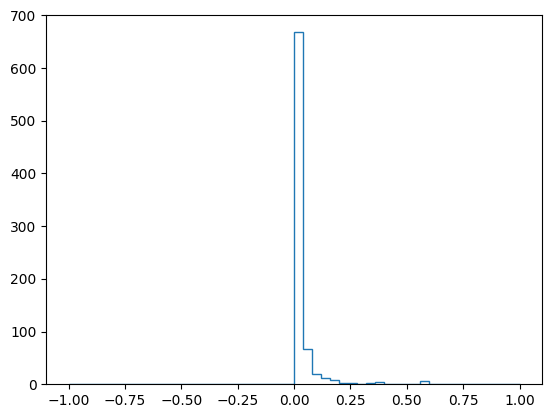

In [113]:
plt.hist(new_errs2, bins=50, range=(-1,1), histtype='step', label='2m adjusted errors');


***

Start by taking a close look at the data, first by inspecting the numbers in the data file (yeps, print the damn thing, and look over the numbers!), and then by considering the histograms produced by running the notebook. To begin with, only consider the 30cm ruler measurements, and disregard the estimated/guessed uncertainties. You can then expand from there, as guided below by questions.


# Questions:

1. Consider the mean, standard deviation, and uncertainty on the mean. Is the result as you would expect it? And do you think that it is close to the best possible (i.e. most accurate and precise) estimate? NOTE: Make sure that you know the difference between accuracy and precision!!! See "Common definition" in: http://en.wikipedia.org/wiki/Accuracy_and_precision

2. Do any of the measurements looks wrong/bad/suspicious? Do you see any repeated mistakes done for obvious reasons? Would you correct or exclude any of the measurements and how would you justify this? This problem requires that you discuss with your peers, and then each do what you think most justified/best. It somehow boils down to how far away a measurement is from the expectation.
Apply the criterion you find fitting to the list of measurements, and perhaps produce a new list with your accepted and possibly corrected measurements in (to save the original data). How many measurements did you throw away in the end?

3. Fit your accepted length measurements with a Gaussian distribution, possibly in a (small?) range around what you believe is the true value. What would be your strategy for choosing a range? Is the Gaussian distribution justified? Also, do you see any "human" effects? Did any of your class mates (or you?) not read to mm precision and rounded the result?

4. Once you have selected the measurements you want to use, calculate the mean, standard deviation, and uncertainty on the mean. How much did your result improve in precision from the raw data in question 1?

5. Now consider also the uncertainties. Try to calculate the weighted mean. Did you get a good Chi2 probability, when doing so? Or are some measurements and/or uncertainties doubtful?

6. In order to consider measurements in light of their uncertainties, one uses the "Pull" distribution. It is defined as the plot of $z_i = \left(x_i - \overline{x} \right)/\sigma_i$ where $\overline{x}$ is the *sample* mean of $x$, and $x_i$ and $\sigma_i$ are the *single measurements* and their corresponding uncertainties. If the measurements and uncertainties are good, then it should give a unit Gaussian. Is that the case? And thus, were the uncertainty estimates/guesses reasonable? If not, then the pull distribution is often used to remove overly precise measurements (those far out on the tails), and afterwards to scale the errors on the remaining measurements to a reasonable level. Consider the pull distribution, and see if any measurements have suspicious uncertainties. Did the Chi2 probablity improve? And did the result improve further in precision? If not, why could that be?

7. Is the number of mismeasurements 30cm below the actual length more common than those 30cm above? Determine the ratio $r_{miss} = N_{30cm~high} / N_{30cm~low}$ including both its statistical uncertainty, and if possible a systematic uncertainty from defining exactly when a measurement is 30cm off.



#### Now repeat the above for the 2m folding rule
...and consider all the questions below as optional problems, where you might just try to solve selected problems.
 
***

8. How much better/worse is the single measurement uncertainty from the 30cm ruler case to the 2m folding rule?

9. Does the length of the table seems to be different when measured with a 30cm and a 2m ruler? Quantify this statement! I.e. what is the difference, and what is the uncertainty on that difference? Is this significantly away from 0?

10. If you were asked for the best estimate of the length of the table, what would you do? (If posssible, read Bevington page 58 bottom!)


### Advanced questions:

11. Is there any correlation between the errors on the measurements and the distance value? I.e. do you see any effect of those measuring e.g. too long having a smaller/larger uncertainty? What would the effect of this be?

# Learning points:

This is a "open" and potentially long exercise, which in essense is meant to illustrate how challeging real data can be, even if it is conceptually simple and in one dimension.

The first learning point is that real data is potentially very complicated, and requires consideration/processing before being as clear cut, as what we simulate. Two approaches could be:
1. A crude/fast *"cut the non-standard (wrong?) measurements away"* analysis, potentially missing something.
2. A detailed *"plot a lot and consider every single point"*, potentially (over-?)using a lot of time.

From this exercise, you should have learned:
1. Always **start by plotting the data**, and ask yourself, if the distributions make sense.
2. In order to remove potential mis-measurements, one uses **Chauvenet's Criterion** and rejects points with a low probability of being correct.
3. Alternatively, one corrects data points (calibration) based on **understanding the reason(s) for these shifts**. 
4. Once the data has been cleaned (distributions Gaussian?), one can apply the usual calculations of mean $\mu$, Standard Deviation $\sigma$, and uncertainty on the mean $\sigma_{\mu}$.
5. When considering **data with uncertainties, the data cleaning is different**, as one considers how far away potential mis-measurements are in units of their uncertainty.
6. **It is always important to have ways of cross checking one's results**, in this case comparing the 30cm ruler with the 2m folding rule result.
7. An alternative method of estimating the length is by fitting the entire distribution with a combination of PDFs (Gaussians). In this way, one avoids excluding data, but rather model the mistakes made.